# Diffusion Image Generation on CIFAR10

In this notebook I am implementing a UNet Diffusion model for the task of Conditional Image Generation on CIFAR10 Dataset.

In [1]:
!pip install numpy pandas torch torchvision torchmetrics matplotlib mplcyberpunk

## Importing libraries:

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import MSELoss
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms 
from PIL import Image
from tqdm import tqdm
import os
import time
import gc
import math
import mplcyberpunk
plt.style.use('cyberpunk')
device = "cuda:3" if torch.cuda.is_available() else "cpu"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ["TORCH_USE_CUDA_DSA"] = "1"

## Data extraction and processing:

In [3]:
train_set = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True)

test_set = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, device):
        self.images = images
        self.labels = labels
        self.device = device

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).to(self.device)
        image = (image - image.min()) / (image.max() - image.min()) * 2 - 1
        label = torch.tensor(self.labels[idx]).to(self.device)
        return image, label


In [5]:
train_dataset = ImageDataset(train_set.data, train_set.targets, device)
test_dataset = ImageDataset(test_set.data, test_set.targets, device)

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=32,
                          shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                          batch_size=32,
                          shuffle=True)

## Visualizing the dataset:

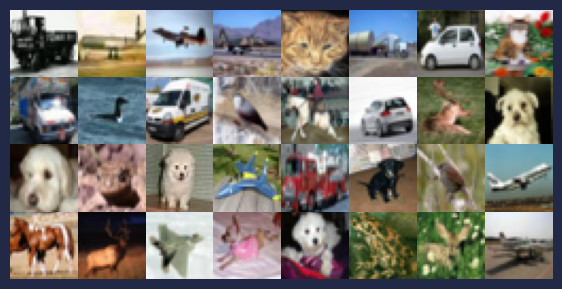

labels are: tensor([9, 0, 0, 0, 3, 9, 1, 3, 9, 2, 9, 2, 7, 1, 4, 5, 5, 6, 5, 0, 9, 5, 2, 0,
        7, 4, 0, 5, 5, 6, 4, 0], device='cuda:3')


In [6]:
def imshow(img):
    plt.figure(figsize=(7, 3.5))

    for i in range(32):
        plt.subplot(4, 8, i + 1)
        plt.imshow(((img[i]+1)/2).cpu().detach().numpy())
        plt.axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

for images, labels in train_loader:
    imshow(images)
    print(f"labels are: {labels}")
    break

## Defining noise scheduler:

In [7]:
def cosine_schedule(num_timesteps, s=0.008):
    def f(t):
        return torch.cos((t / num_timesteps + s) / (1 + s) * 0.5 * torch.pi) ** 2
    x = torch.linspace(0, num_timesteps, num_timesteps + 1)
    alphas_cumprod = f(x) / f(torch.tensor([0]))
    betas = 1 - alphas_cumprod[1:] / alphas_cumprod[:-1]
    betas = torch.clip(betas, 0.0001, 0.999)
    return betas

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    
    t_copy = t.clone().to(vals.device)
    
    out = vals.gather(-1, t_copy)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(device)

def forward_diffusion_sample(x_0, t, device="cpu"):
    """ 
    Takes a batch of images and timesteps as input and 
    returns the noisy versions of them.
    """
    # Generate noise for the entire batch
    noise = torch.randn_like(x_0)

    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    
    noisy_images = sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + \
                   sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device)

    return noisy_images, noise



# Define beta schedule
T = 300
betas = cosine_schedule(num_timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# Simulate forward diffusion:


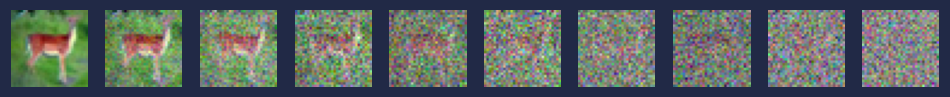

In [8]:
image = next(iter(train_loader))[0]
image = image[:1]

plt.figure(figsize=(12, 1))
plt.axis('off')
num_images = 10
stepsize = T // num_images

for idx, step in enumerate(range(0, T,  stepsize)):

    t = torch.full((image.shape[0],), step, dtype=torch.int64).to(image.device)
    img, noise = forward_diffusion_sample(image, t, device=device)

    img_min, img_max = img.min(), img.max()
    img_normalized = (img - img_min) / (img_max - img_min)

    plt.subplot(1, num_images, idx + 1)
    plt.imshow(img_normalized.squeeze().cpu().detach().numpy())
    plt.axis('off')

plt.show()


## Backward process:

In [9]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()
        
    def forward(self, x, t, ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)

        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32
        num_classes = 10

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        # Class embedding (conditional model)
        self.class_emb = nn.Embedding(num_classes, time_emb_dim)
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep, class_label):
        # Embedd time
        t = self.time_mlp(timestep)
        # Add embedded Class -> Makes the model Conditional on the given class
        t = t + self.class_emb(class_label)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

model = SimpleUnet()
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Number of parameters:  62439203


## Defining Loss function:

In [10]:
def get_loss(model, x_0, t, class_label):
    x_noisy, noise = forward_diffusion_sample(x_0, t, device)
    noise_pred = model(x_noisy, t, class_label)
    return F.l1_loss(noise, noise_pred)

## Defining sampling functions:

In [11]:
@torch.no_grad()
def sample_timestep(x, t, class_label):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t, class_label) / sqrt_one_minus_alphas_cumprod_t
    )
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(class_label):
    img_size = 32
    img = torch.randn((1, 3, img_size, img_size), device=device)
    plt.figure(figsize=(12,1))
    plt.axis('off')
    plt.title(f"sample for class {train_set.classes[class_label.item()]}")
    
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]:
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, class_label)
        img_min, img_max = img.min(), img.max()
        img = ((img - img_min) / (img_max - img_min)) * 2 - 1
        
        if i % stepsize == 0:
            plt.subplot(1, num_images, num_images-int(i/stepsize))
            img_normalized = (img + 1)/2
            new_img = img_normalized.squeeze().permute(1,2,0).detach().cpu().numpy()
            plt.axis('off')
            plt.imshow(new_img)
            plt.grid(False)
    plt.show()

# Training loop:

In [ ]:
model.to(device)
model.train()
optimizer = Adam(model.parameters(), lr=0.003)
epochs = 50
loss_history = []

for epoch in range(0, epochs):
    mean_loss = 0 
    with tqdm(train_loader, desc=f"Epoch {epoch}", leave=True) as pbar:
        for batch, label in pbar:
    
            batch_size = batch.shape[0] 
            t = torch.randint(0, T, (batch_size,), device=device).long()
            loss = get_loss(model, batch.permute(0,3,1,2).to(device), t, label.to(device))
            mean_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix({"Loss": loss.item()})
    
    mean_loss /= len(train_loader)
    loss_history.append(mean_loss)

    if epoch % 5 == 0:
        print(f"Epoch {epoch} | Loss: {mean_loss} ")
        torch.save(model, "Conditional-Diffusion-Model-CIFAR10.pth")

Epoch 0: 100%|███████████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 42.89it/s, Loss=0.158]


Epoch 0 | Loss: 0.21590379625082168 


Epoch 5: 100%|███████████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 42.97it/s, Loss=0.168]


Epoch 5 | Loss: 0.17818793616783749 


Epoch 10: 100%|██████████████████████████████████████████████████████| 1563/1563 [00:35<00:00, 43.66it/s, Loss=0.188]


Epoch 10 | Loss: 0.1717095039951748 


Epoch 15: 100%|██████████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 43.31it/s, Loss=0.174]


Epoch 15 | Loss: 0.16882959798083272 


Epoch 20: 100%|███████████████████████████████████████████████████████| 1563/1563 [00:36<00:00, 43.33it/s, Loss=0.14]


Epoch 20 | Loss: 0.16760355357607434 


Epoch 24:  84%|█████████████████████████████████████████████▌        | 1320/1563 [00:29<00:05, 44.19it/s, Loss=0.183]

# Loss for the test set:

In [12]:
model = torch.load("Conditional-Diffusion-Model-CIFAR10.pth", weights_only=False)

In [14]:
test_loss = 0 
with tqdm(test_loader, leave=True) as pbar:
    for batch, label in pbar:

        t = torch.randint(0, T, (batch.shape[0],), device=device).long()
        loss = get_loss(model, batch.permute(0,3,1,2).to(device), t, label.to(device))
        test_loss += loss.item()
        pbar.set_postfix({"Loss": loss.item()})

test_loss /= len(test_loader)
print(f"Loss on the Test set: {test_loss}")

100%|██████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 83.18it/s, Loss=0.181]

Loss on the Test set: 0.16006557041178116


# Plotting the generated images:

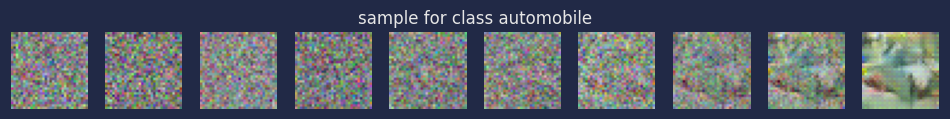

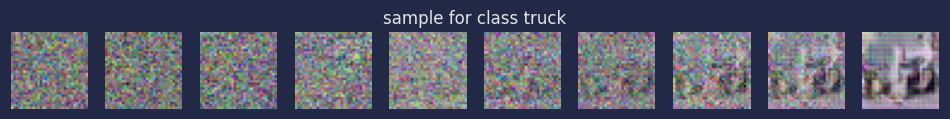

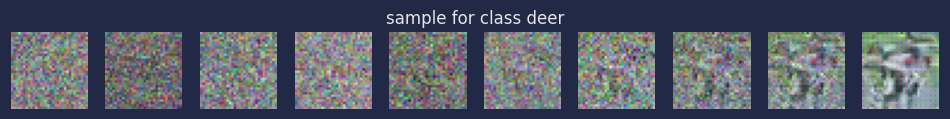

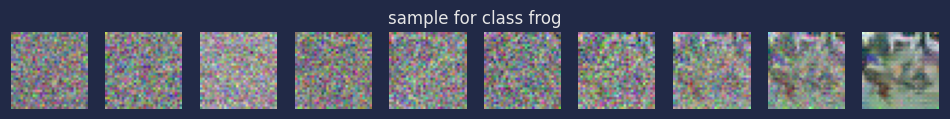

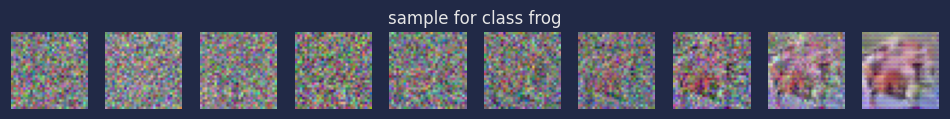

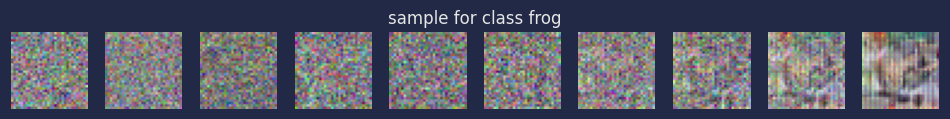

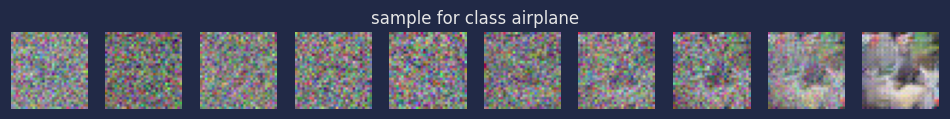

In [16]:
for i in range(7):
    random_class = torch.randint(low=0, high=10, size=(1,)).to(device)
    sample_plot_image(random_class)